In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
import ast
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
conversations = pd.read_csv(
    "/Users/nishithranjanbiswas/Desktop/NLP/Cornell-Movie-Dialog-Analysis-NLP-Course-Project-/data/movie_conversations.tsv", 
    sep='\t', 
    encoding='ISO-8859-2',
    names = ['charID_1', 'charID_2', 'movieID', 'conversation']
)

In [3]:
lines = pd.read_csv(
    "/Users/nishithranjanbiswas/Desktop/NLP/Cornell-Movie-Dialog-Analysis-NLP-Course-Project-/data/movie_lines.tsv", 
    encoding='utf-8-sig', 
    sep='\t', 
    on_bad_lines="skip", 
    header = None,
    names = ['lineID', 'charID', 'movieID', 'charName', 'text'],
    index_col=['lineID']
)

In [4]:
characters = pd.read_csv(
    "/Users/nishithranjanbiswas/Desktop/NLP/Cornell-Movie-Dialog-Analysis-NLP-Course-Project-/data/movie_characters_metadata.tsv", 
    sep='\t', 
    header = None,
    on_bad_lines= "skip",
    names = ['charID','charName','movieID','movieName','gender','score'],
    index_col=['charID']
)

In [5]:
titles = pd.read_csv(
    "/Users/nishithranjanbiswas/Desktop/NLP/Cornell-Movie-Dialog-Analysis-NLP-Course-Project-/data/movie_titles_metadata.tsv",
    sep='\t',
    header=None,
    on_bad_lines="skip",
    names=['movieID', 'title', 'year', 'ratingIMDB', 'votes', 'genresIMDB'],
    index_col=['movieID']
)

In [6]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nishithranjanbiswas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nishithranjanbiswas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
def check_columns_existence(df, columns):
    for col in columns:
        if col not in df.columns:
            print(f"The column '{col}' does not exist in DataFrame")
        else:
            print(f"The column '{col}' exists in DataFrame")

# Check if columns exist in each DataFrame
check_columns_existence(characters, ['charName'])
check_columns_existence(titles, ['title'])
check_columns_existence(lines, ['charName', 'text'])
check_columns_existence(conversations, ['charID_1', 'charID_2', 'movieID', 'conversation'])

The column 'charName' exists in DataFrame
The column 'title' exists in DataFrame
The column 'charName' exists in DataFrame
The column 'text' exists in DataFrame
The column 'charID_1' exists in DataFrame
The column 'charID_2' exists in DataFrame
The column 'movieID' exists in DataFrame
The column 'conversation' exists in DataFrame


In [8]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617 entries, m0 to m616
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       616 non-null    object 
 1   year        616 non-null    object 
 2   ratingIMDB  616 non-null    float64
 3   votes       616 non-null    float64
 4   genresIMDB  616 non-null    object 
dtypes: float64(2), object(3)
memory usage: 28.9+ KB


In [9]:
titles.head()

,title,year,ratingIMDB,votes,genresIMDB
movieID,,,,,
m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


In [10]:
# Check for missing values
print(titles.isnull().sum())

title         1
year          1
ratingIMDB    1
votes         1
genresIMDB    1
dtype: int64


/Users/nishithranjanbiswas/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


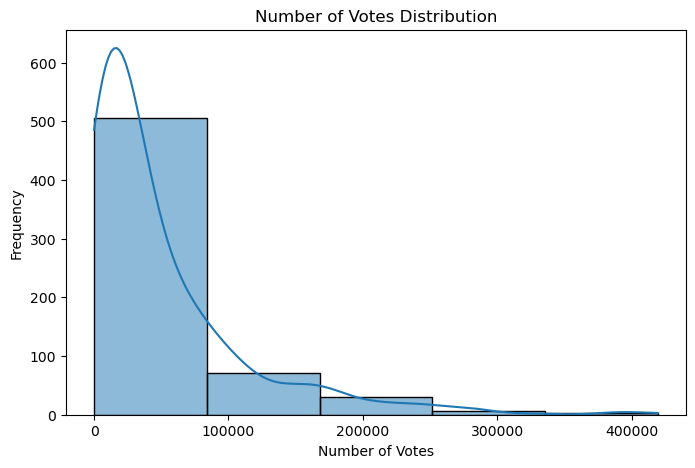

In [11]:
# Number of Votes Distribution
plt.figure(figsize=(8, 5))
sns.histplot(titles['votes'], bins=5, kde=True)
plt.title('Number of Votes Distribution')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.show()

In [12]:
ratings_list = titles['ratingIMDB'].tolist()
print(ratings_list)

[6.9, 6.2, 6.1, 8.4, 6.9, 7.5, 6.3, 5.2, 4.7, 4.9, 6.9, 6.3, 5.8, 7.8, 6.1, 8.5, 8.4, 7.5, 7.4, 5.7, 7.4, 6.0, 7.1, 3.4, 5.9, 6.6, 6.9, 6.3, 8.1, 6.3, 8.1, 6.0, 7.1, 6.4, 8.3, 6.4, 7.8, 7.8, 7.2, 7.6, 8.4, 7.8, 8.8, 7.5, 7.5, 6.8, 7.2, 6.5, 5.3, 6.5, 8.3, 6.3, 8.1, 8.4, 5.9, 8.5, 4.0, 6.4, 5.7, 7.2, 7.6, 6.4, 7.2, 8.0, 5.6, 7.1, 5.6, 4.9, 7.2, 7.5, 6.9, 5.3, 7.7, 6.6, 6.1, 6.9, 8.4, 8.2, 7.7, 7.0, 5.4, 4.5, 5.8, 6.7, 8.1, 6.2, 6.8, 7.0, 7.6, 7.2, 8.1, 7.4, 5.6, 6.3, 8.2, 7.1, 6.4, 6.6, 8.3, 7.5, 6.5, 8.0, 6.4, 8.3, 8.0, 7.6, 7.5, 4.4, 8.3, 7.9, 6.7, 6.8, 5.8, 5.9, 8.6, 4.5, 7.6, 6.2, 6.2, 7.5, 7.3, 5.0, 6.7, 7.6, 7.8, 7.0, 7.7, 6.4, 7.7, 7.7, 7.7, 7.8, 7.7, 5.3, 8.4, 8.2, 5.5, 4.5, 6.7, 8.4, 8.0, 6.8, 6.9, 5.9, 5.5, 5.4, 6.2, 8.2, 7.4, 7.9, 7.1, 8.3, 6.4, 7.8, 6.8, 6.9, 5.9, 6.9, 6.3, 7.2, 6.7, 6.9, 7.5, 7.4, 7.3, 7.1, 8.4, 8.7, 7.9, 5.5, 8.4, 6.9, 4.7, 6.4, 6.9, 7.1, 6.5, 5.4, 7.8, 6.9, 7.0, 8.3, 8.2, 4.2, 6.6, 6.6, 6.6, 6.2, 6.1, 7.4, 8.2, 6.5, 6.5, 7.8, 7.3, 6.3, 7.6, 7.2, 6.4, 6.9,

/Users/nishithranjanbiswas/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


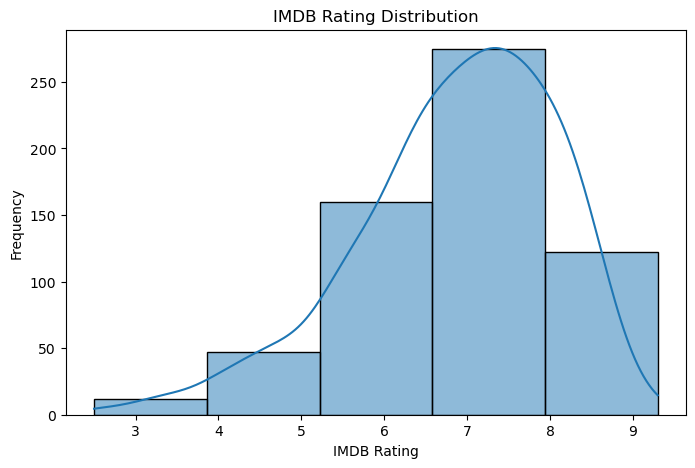

In [13]:
# IMDB Rating Distribution
plt.figure(figsize=(8, 5))
sns.histplot(titles['ratingIMDB'], bins=5, kde=True)
plt.title('IMDB Rating Distribution')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency')
plt.show()

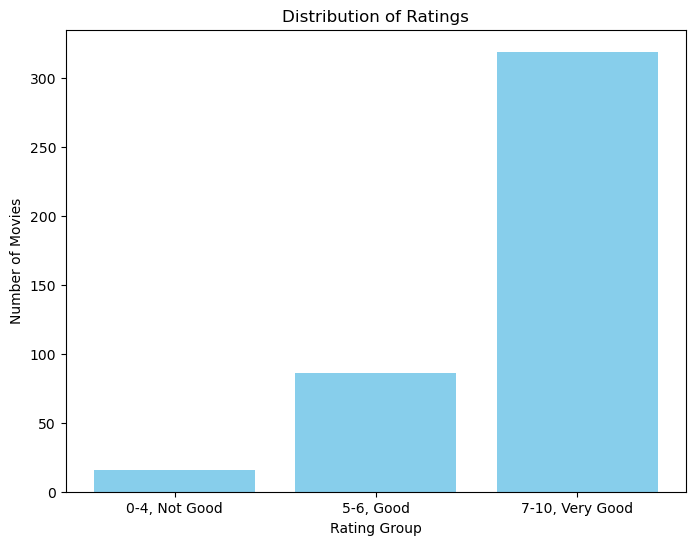

In [14]:
# Categorize ratings into 3 groups (0-4, 5-6, 7-10)
rating_groups = {
    '0-4, Not Good': sum(1 for rating in ratings_list if rating <= 4),
    '5-6, Good': sum(1 for rating in ratings_list if 5 <= rating <= 6),
    '7-10, Very Good': sum(1 for rating in ratings_list if rating >= 7)
}

# Plotting the data
plt.figure(figsize=(8, 6))
plt.bar(rating_groups.keys(), rating_groups.values(), color='skyblue')
plt.xlabel('Rating Group')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings')
plt.show()

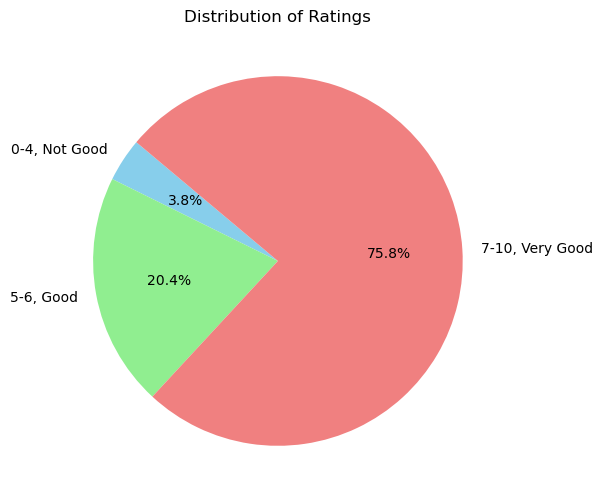

In [15]:
# Plotting the data
plt.figure(figsize=(8, 6))
plt.pie(rating_groups.values(), labels=rating_groups.keys(), autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Distribution of Ratings')
plt.show()

In [16]:
def search_movie_rating(title):
    # Search for the movie by title and get its rating
    movie_rating = titles.loc[titles['title'].str.contains(title, case=False, na=False), 'ratingIMDB']
    
    if not movie_rating.empty:
        return movie_rating.values[0]
    else:
        return "Movie not found or no rating available."

# Example usage:
#movie_to_search = input("Enter the title of the movie to search for: ")
movie_to_search= '48 hrs.'
rating = search_movie_rating(movie_to_search)
print(f"The rating for '{movie_to_search}' is: {rating}")

The rating for '48 hrs.' is: 6.9


/Users/nishithranjanbiswas/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


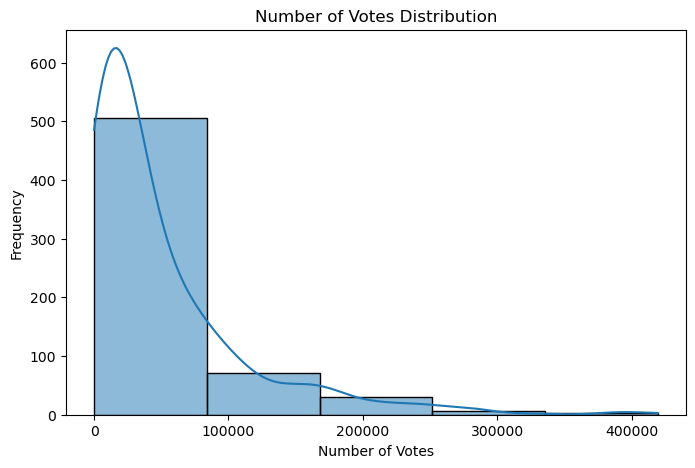

In [17]:
# Number of Votes Distribution
plt.figure(figsize=(8, 5))
sns.histplot(titles['votes'], bins=5, kde=True)
plt.title('Number of Votes Distribution')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.show()

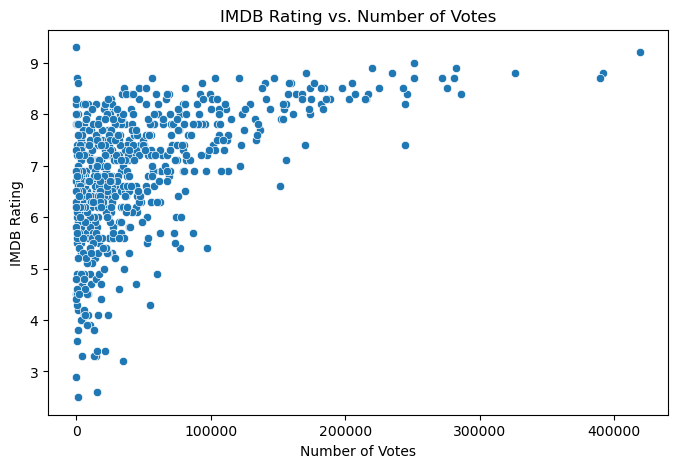

In [18]:
# IMDB Rating vs. Number of Votes
plt.figure(figsize=(8, 5))
sns.scatterplot(x='votes', y='ratingIMDB', data=titles)
plt.title('IMDB Rating vs. Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('IMDB Rating')
plt.show()

movie to genres 

In [19]:
def get_genre_list(genres):
    genre_list = genres['genresIMDB'].tolist()
    return genre_list

In [20]:
genre_list = get_genre_list(titles)
print(genre_list[:10])

["['comedy' 'romance']", "['adventure' 'biography' 'drama' 'history']", "['action' 'crime' 'drama' 'thriller']", "['adventure' 'mystery' 'sci-fi']", "['action' 'comedy' 'crime' 'drama' 'thriller']", "['action' 'adventure' 'romance' 'sci-fi' 'thriller']", "['crime' 'mystery' 'thriller']", "['fantasy' 'horror' 'thriller']", "['fantasy' 'horror' 'thriller']", "['sci-fi' 'thriller']"]


In [21]:
type(genre_list)

list

In [22]:
# Initialize an empty list to store all genres
all_genres = []

# Loop through each nested list and extract genres
for genres in genre_list:
    if isinstance(genres, str):
        # Remove the brackets and split the string into individual genres
        cleaned_genres = genres.strip("[]").replace("'", "").split()
        # Extend the all_genres list with the cleaned genres
        all_genres.extend(cleaned_genres)

# Convert the list to a set to remove duplicates and then back to a sorted list
unique_genres_list = sorted(set(all_genres))

# Display the unique genres
print(unique_genres_list)

['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sci-fi', 'short', 'sport', 'thriller', 'war', 'western']


In [23]:
len(all_genres)

1868

In [24]:
print(all_genres)

['comedy', 'romance', 'adventure', 'biography', 'drama', 'history', 'action', 'crime', 'drama', 'thriller', 'adventure', 'mystery', 'sci-fi', 'action', 'comedy', 'crime', 'drama', 'thriller', 'action', 'adventure', 'romance', 'sci-fi', 'thriller', 'crime', 'mystery', 'thriller', 'fantasy', 'horror', 'thriller', 'fantasy', 'horror', 'thriller', 'sci-fi', 'thriller', 'drama', 'mystery', 'thriller', 'action', 'drama', 'thriller', 'comedy', 'romance', 'sci-fi', 'comedy', 'romance', 'crime', 'drama', 'sci-fi', 'thriller', 'action', 'sci-fi', 'thriller', 'biography', 'drama', 'music', 'horror', 'romance', 'drama', 'action', 'western', 'drama', 'thriller', 'drama', 'thriller', 'action', 'adventure', 'comedy', 'crime', 'action', 'adventure', 'thriller', 'comedy', 'romance', 'action', 'crime', 'drama', 'mystery', 'thriller', 'crime', 'drama', 'comedy', 'drama', 'music', 'drama', 'romance', 'war', 'crime', 'drama', 'mystery', 'thriller', 'adventure', 'drama', 'fantasy', 'comedy', 'crime', 'roman

In [25]:
len(unique_genres_list)

24

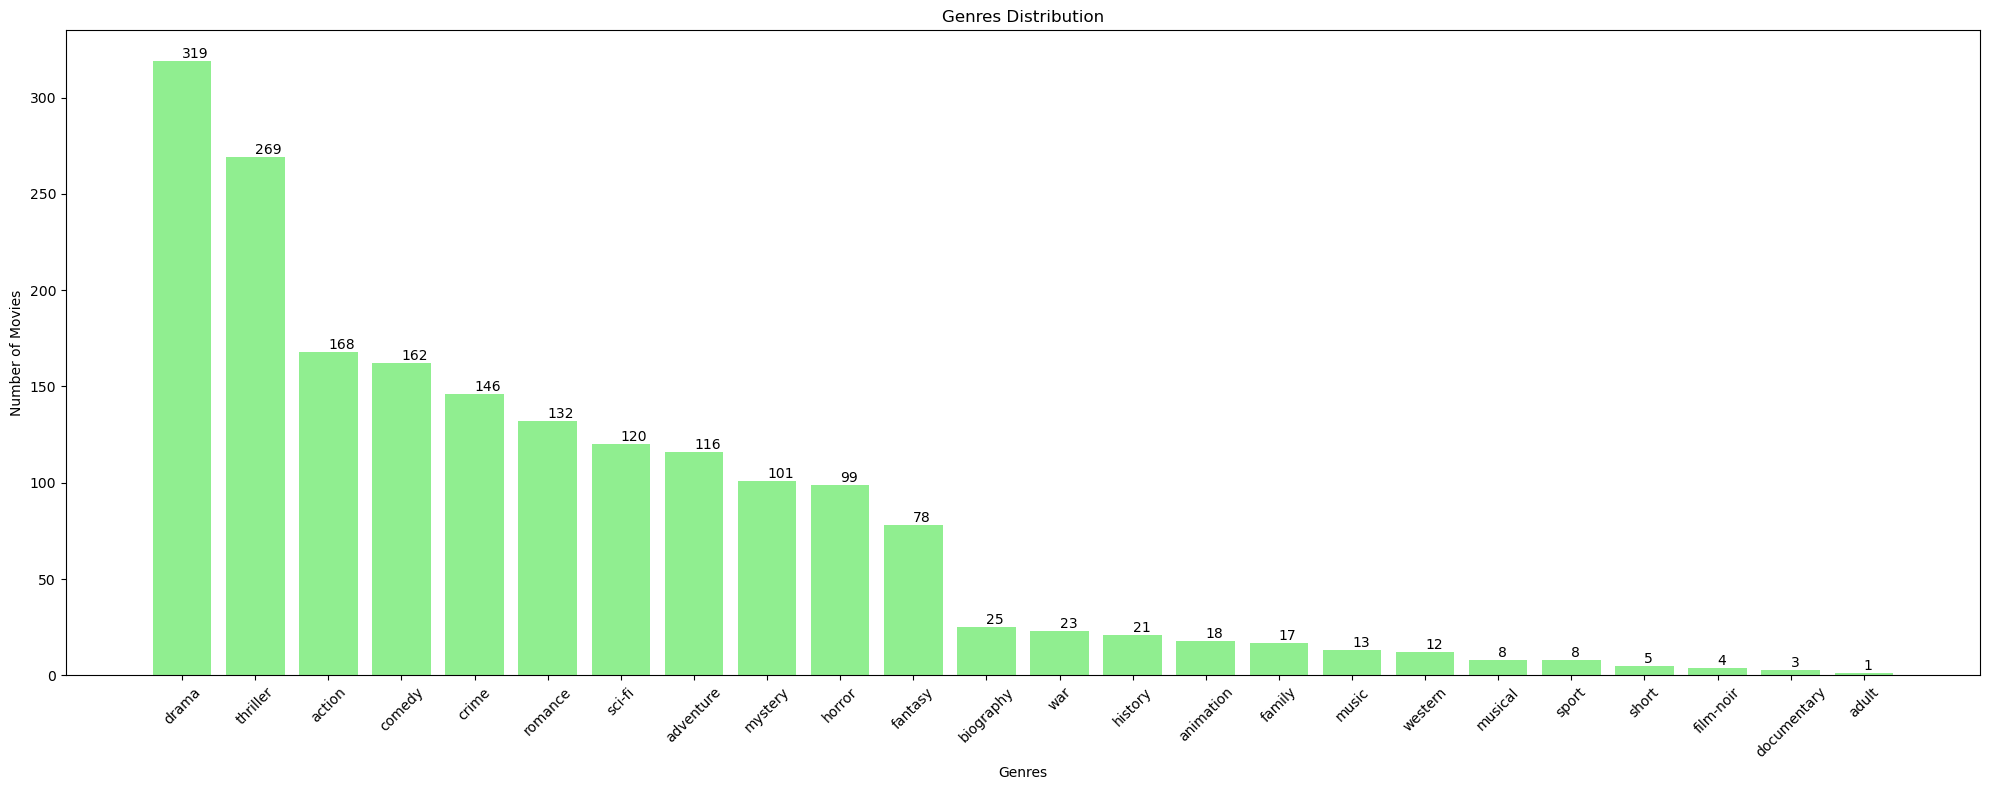

In [26]:
# Count the frequency of each word
word_counts = {}
for word in all_genres:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

# Create a DataFrame from the word counts
df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency
df = df.sort_values(by='Frequency', ascending=False)

# Plotting the data
plt.figure(figsize=(20, 8))
bars = plt.bar(df['Word'], df['Frequency'], color='lightgreen')
plt.bar(df['Word'], df['Frequency'], color='lightgreen')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.title('Genres Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add text labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.tight_layout()
plt.show()

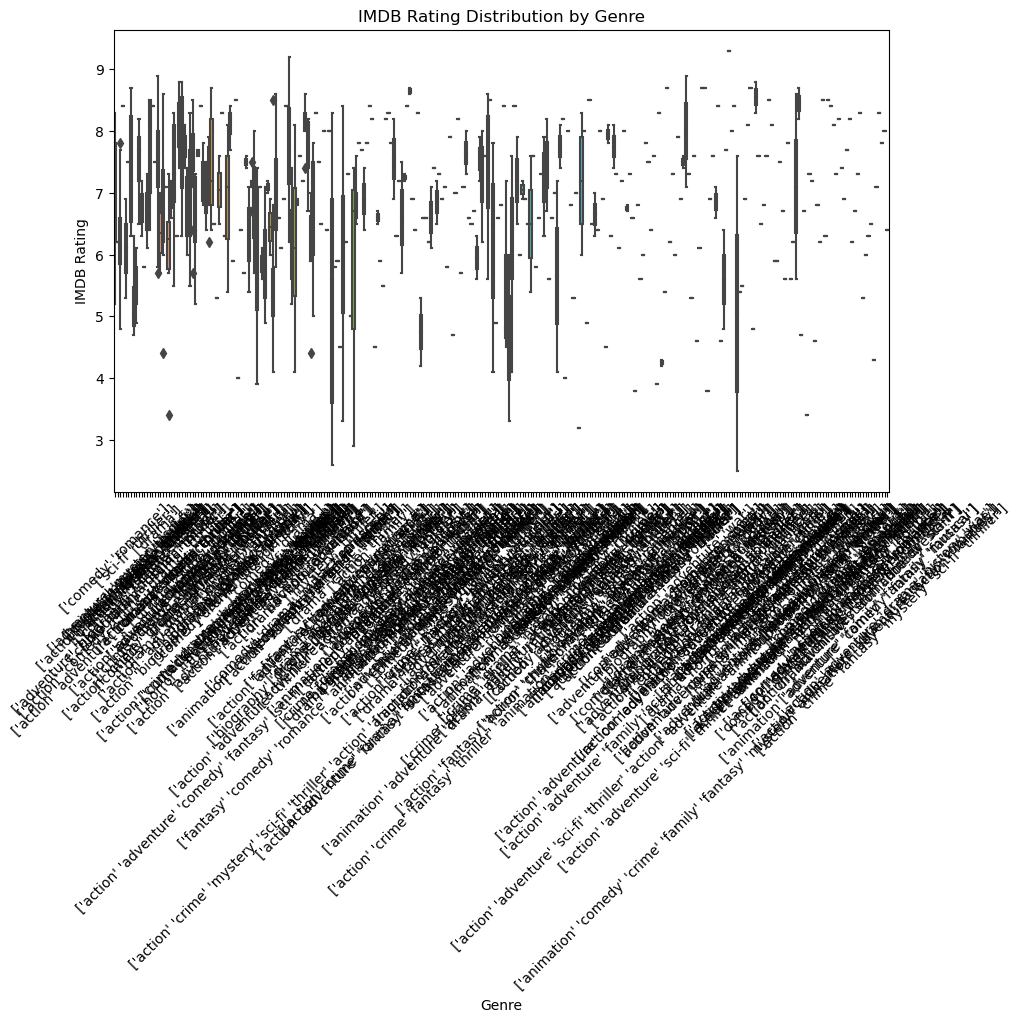

In [27]:
# Explode genres list to separate rows
genres_exploded = titles.explode('genresIMDB')

# IMDB Rating Distribution by Genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='genresIMDB', y='ratingIMDB', data=genres_exploded)
plt.title('IMDB Rating Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('IMDB Rating')
plt.xticks(rotation=45)
plt.show()

In [28]:
df= titles
def find_genres(keyword):
    # Search for the keyword in the movie titles (case insensitive)
    matching_movies = df[df['title'].str.contains(keyword, case=False, na=False)]
    
    if not matching_movies.empty:
        # If there's a match, return the movie title and genres as a list of tuples
        x = [(row['title'], row['genresIMDB']) for index, row in matching_movies.iterrows()]
        # Convert list to dictionary
        result_dict = {key: [genre.strip("'") for genre in value.strip("[]").split(", ")] for key, value in x}
        # Convert dictionary to string
        os = f"Movie: {list(result_dict.keys())[0]}\nGenres = {result_dict[list(result_dict.keys())[0]]}"
        return os
    else:
        return "No matching movie found."

#movie_name = input("Enter the title of the movie to search genre: ")
movie_name= '48 hrs.'
genres = find_genres(movie_name)
print(genres)

Movie: 48 hrs.
Genres = ["action' 'comedy' 'crime' 'drama' 'thriller"]


In [29]:
titles.head()

,title,year,ratingIMDB,votes,genresIMDB
movieID,,,,,
m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


Find movie list based on genre

In [30]:
def find_movies_by_genre(dataframe, genre):
    # Create a copy of the dataframe to avoid modifying the original
    dataframe_copy = dataframe.copy()
    
    # Replace NaN values with an empty list in the 'genresIMDB' column in the copy
    dataframe_copy['genresIMDB'].fillna('[]', inplace=True)
    
    # Convert the genre column to a list of strings in the copy
    dataframe_copy['genresIMDB'] = dataframe_copy['genresIMDB'].apply(ast.literal_eval)
    
    # Convert genre to lowercase for case-insensitive matching
    genre_lower = genre.lower()
    
    # Filter the copy of the dataframe to find movies with the specified genre
    filtered_movies = dataframe_copy[dataframe_copy['genresIMDB'].apply(lambda x: any(genre_lower in g.lower() for g in x))]
    
    return filtered_movies[['title', 'year', 'ratingIMDB']]

genre_to_search = 'action'
#genre_to_searc = input("Enter the genre to search genre: ")
movies_with_genre = find_movies_by_genre(titles, genre_to_search)
print(f"Movies with genre '{genre_to_search}':")
print(movies_with_genre[:10])

Movies with genre 'action':
                                               title    year  ratingIMDB
movieID                                                                 
m2                                        15 minutes    2001         6.1
m4                                           48 hrs.    1982         6.9
m5                                 the fifth element    1997         7.5
m11                                    air force one    1997         6.3
m15                                           aliens    1986         8.5
m19                                 american outlaws    2001         5.7
m22      austin powers: international man of mystery    1997         7.1
m23                                     the avengers    1998         3.4
m25                                        backdraft    1991         6.6
m33                                       black rain  1989/I         6.4


# Characters Data

In [31]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9034 entries, u0 to u9034
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   charName   9015 non-null   object
 1   movieID    9017 non-null   object
 2   movieName  9017 non-null   object
 3   gender     9017 non-null   object
 4   score      9017 non-null   object
dtypes: object(5)
memory usage: 423.5+ KB


In [32]:
characters.head()

,charName,movieID,movieName,gender,score
charID,,,,,
u0,BIANCA,m0,10 things i hate about you,f,4
u1,BRUCE,m0,10 things i hate about you,?,?
u2,CAMERON,m0,10 things i hate about you,m,3
u3,CHASTITY,m0,10 things i hate about you,?,?
u4,JOEY,m0,10 things i hate about you,m,6


In [33]:
characters['gender'].replace('?', 'unknown', inplace=True)
characters['score'] = pd.to_numeric(characters['score'], errors='coerce')

In [34]:
characters.head()

,charName,movieID,movieName,gender,score
charID,,,,,
u0,BIANCA,m0,10 things i hate about you,f,4.0
u1,BRUCE,m0,10 things i hate about you,unknown,NaN
u2,CAMERON,m0,10 things i hate about you,m,3.0
u3,CHASTITY,m0,10 things i hate about you,unknown,NaN
u4,JOEY,m0,10 things i hate about you,m,6.0


In [35]:
print(characters['gender'].value_counts())

gender
unknown    6008
m          1899
f           921
M           145
F            44
Name: count, dtype: int64


In [36]:
# Data Cleaning
characters['gender'] = characters['gender'].str.lower().replace('?', 'unknown')
characters['score'] = pd.to_numeric(characters['score'], errors='coerce')

# Display cleaned data
print(characters)


             charName movieID                   movieName   gender  score
charID                                                                   
u0             BIANCA      m0  10 things i hate about you        f    4.0
u1              BRUCE      m0  10 things i hate about you  unknown    NaN
u2            CAMERON      m0  10 things i hate about you        m    3.0
u3           CHASTITY      m0  10 things i hate about you  unknown    NaN
u4               JOEY      m0  10 things i hate about you        m    6.0
...               ...     ...                         ...      ...    ...
u9030        DURNFORD    m616                   zulu dawn  unknown    NaN
u9031         MELVILL    m616                   zulu dawn  unknown    NaN
u9032   NORRIS-NEWMAN    m616                   zulu dawn  unknown    NaN
u9033    STUART SMITH    m616                   zulu dawn  unknown    NaN
u9034         VEREKER    m616                   zulu dawn  unknown    NaN

[9034 rows x 5 columns]


In [37]:
print(characters['gender'].value_counts())

gender
unknown    6008
m          2044
f           965
Name: count, dtype: int64


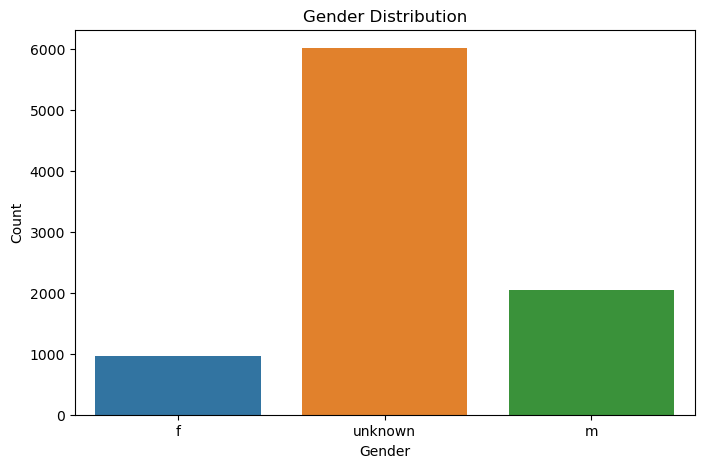

In [38]:
# Gender Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', data=characters)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

/Users/nishithranjanbiswas/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


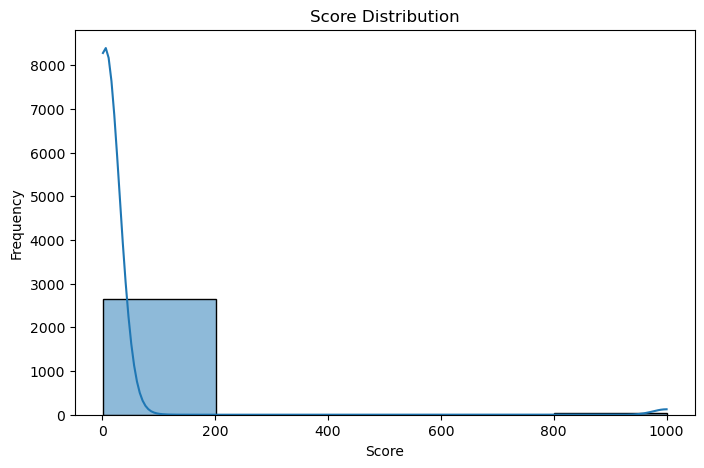

In [39]:
# Score Distribution
plt.figure(figsize=(8, 5))
sns.histplot(characters['score'].dropna(), bins=5, kde=True)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


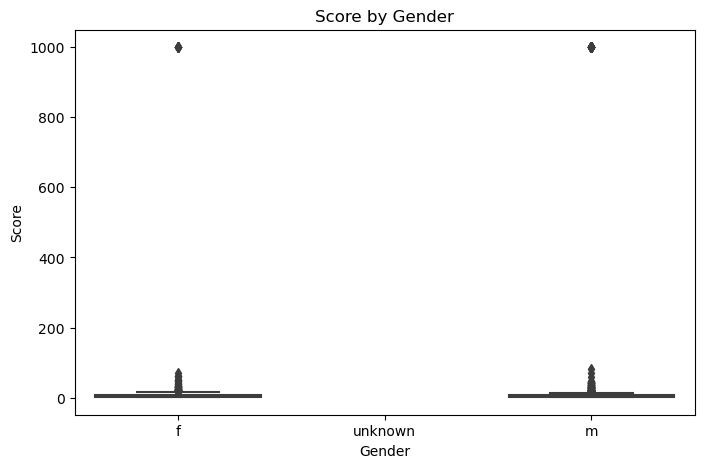

In [40]:
# Score by Gender
plt.figure(figsize=(8, 5))
sns.boxplot(x='gender', y='score', data=characters)
plt.title('Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Score')
plt.show()

# lines

In [41]:
lines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293202 entries, L1045 to L666256
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   charID    288917 non-null  object
 1   movieID   288917 non-null  object
 2   charName  288874 non-null  object
 3   text      288663 non-null  object
dtypes: object(4)
memory usage: 11.2+ MB


In [42]:
lines.head()

,charID,movieID,charName,text
lineID,,,,
L1045,u0,m0,BIANCA,They do not!
L1044,u2,m0,CAMERON,They do to!
L985,u0,m0,BIANCA,I hope so.
L984,u2,m0,CAMERON,She okay?
L925,u0,m0,BIANCA,Let's go.


In [43]:
!pip install textblob

In [44]:
# Convert NaNs to empty strings
lines['text'] = lines['text'].fillna('')

# Convert all values in the 'text' column to strings
lines['text'] = lines['text'].astype(str)


The code calculates two sentiment metrics:

Polarity: A numerical value indicating the positivity or negativity of the text (-1 being very negative, 1 being very positive).
Subjectivity: A numerical value indicating how subjective or objective the text is (0 being very objective, 1 being very subjective).

/Users/nishithranjanbiswas/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


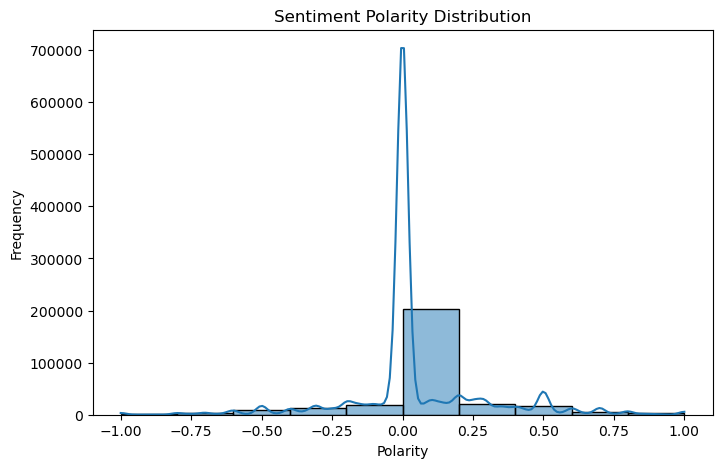

/Users/nishithranjanbiswas/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


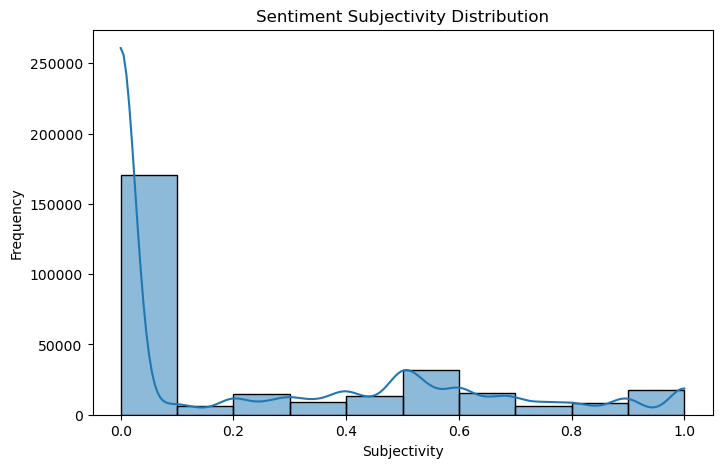

In [45]:
from textblob import TextBlob

# Function to get the sentiment polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis
lines['polarity'], lines['subjectivity'] = zip(*lines['text'].apply(get_sentiment))

# Visualize sentiment polarity
plt.figure(figsize=(8, 5))
sns.histplot(lines['polarity'], bins=10, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

# Visualize sentiment subjectivity
plt.figure(figsize=(8, 5))
sns.histplot(lines['subjectivity'], bins=10, kde=True)
plt.title('Sentiment Subjectivity Distribution')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.show()


In [46]:
!pip install wordcloud

Generating word clouds for characters like Bianca and Cameron can help visualize the most common words they use in their dialogue. 

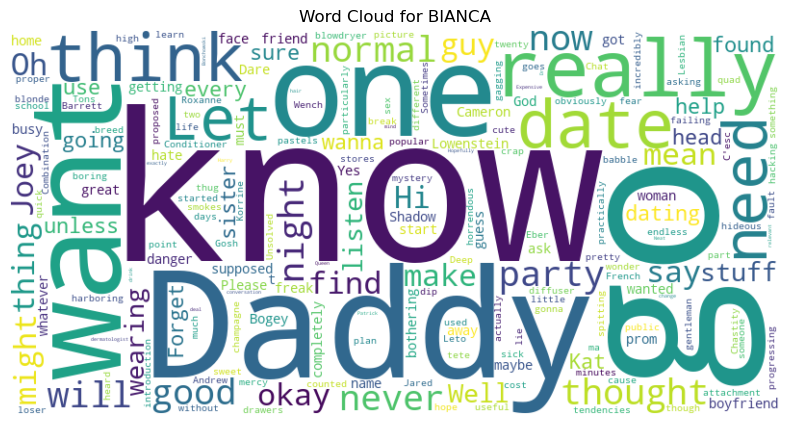

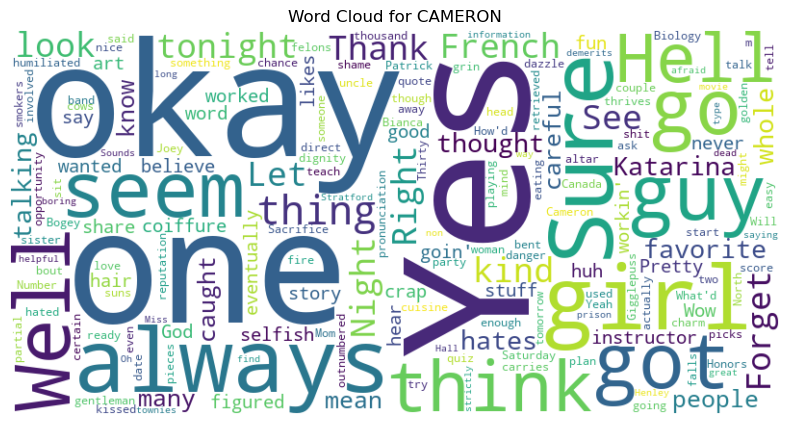

In [47]:
from wordcloud import WordCloud

# Function to generate word cloud for a given character
def generate_wordcloud(character):
    text = ' '.join(lines[lines['charName'] == character]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {character}')
    plt.axis('off')
    plt.show()

# Generate word clouds for BIANCA and CAMERON
generate_wordcloud('BIANCA')
generate_wordcloud('CAMERON')


The distribution of text length provides insights into the typical length, variability, and speech patterns of dialogue lines spoken by characters in the dataset. It helps understand average dialogue length, variability in speech patterns, emotional intensity, engagement levels, and character communication styles. Visualizing this distribution allows for quick insights into the nature of the textual data.

/Users/nishithranjanbiswas/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


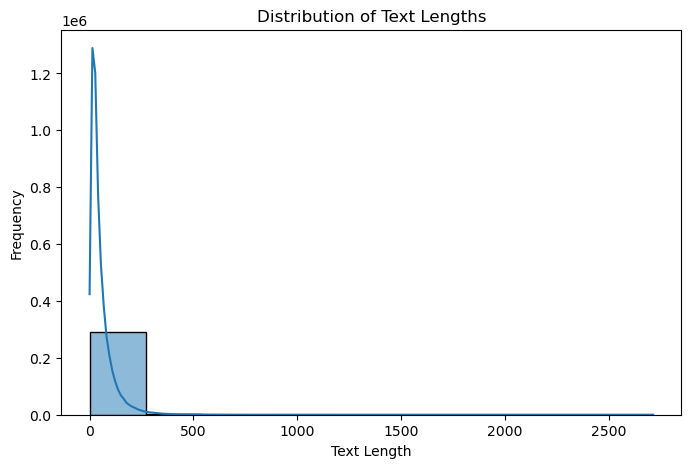

In [48]:
# Add a column for text length
lines['text_length'] = lines['text'].apply(len)

# Distribution of text lengths
plt.figure(figsize=(8, 5))
sns.histplot(lines['text_length'], bins=10, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Conversations

In [49]:
conversations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83097 entries, 0 to 83096
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   charID_1      83097 non-null  object
 1   charID_2      83097 non-null  object
 2   movieID       83097 non-null  object
 3   conversation  83097 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [50]:
conversations.head()

,charID_1,charID_2,movieID,conversation
0,u0,u2,m0,['L194' 'L195' 'L196' 'L197']
1,u0,u2,m0,['L198' 'L199']
2,u0,u2,m0,['L200' 'L201' 'L202' 'L203']
3,u0,u2,m0,['L204' 'L205' 'L206']
4,u0,u2,m0,['L207' 'L208']


In [51]:
def get_movie_list(movies):
    movie_list = movies['title'].tolist()
    return movie_list

In [52]:
movie_list = get_movie_list(titles)
print(movie_list[:10])

['10 things i hate about you', '1492: conquest of paradise', '15 minutes', '2001: a space odyssey', '48 hrs.', 'the fifth element', '8mm', 'a nightmare on elm street 4: the dream master', 'a nightmare on elm street: the dream child', 'the atomic submarine']


In [53]:
len(movie_list)

617

In [54]:
def get_chracter_list(character):
    character_list = character['charName'].tolist()
    return character_list

In [55]:
character_list = get_chracter_list(characters)
print(character_list[:10])

['BIANCA', 'BRUCE', 'CAMERON', 'CHASTITY', 'JOEY', 'KAT', 'MANDELLA', 'MICHAEL', 'MISS PERKY', 'PATRICK']


In [56]:
len(character_list)

9034

In [57]:
index_labels = titles.index
print(index_labels)

Index(['m0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9',
       ...
       'm607', 'm608', 'm609', 'm610', 'm611', 'm612', 'm613', 'm614', 'm615',
       'm616'],
      dtype='object', name='movieID', length=617)


In [58]:
def extract_conversations_for_movies(movies_list, characters, movies, lines, conversations):
    movie_ids = [movies[movies['title'] == movie_title].index[0] for movie_title in movies_list]
    movie_conversations = {}

    for movie_id in movie_ids:
        # Get all conversations for this movie
        relevant_convos = conversations[conversations['movieID'] == movie_id]
        
        # If the movie title isn't already in the dictionary, add it with an empty list
        movie_title = movies.loc[movie_id].title
        if movie_title not in movie_conversations:
            movie_conversations[movie_title] = []
        
        # Loop through the relevant conversations
        for i, conversation in relevant_convos.iterrows():
            char_name1 = characters.loc[conversation['charID_1']].charName
            char_name2 = characters.loc[conversation['charID_2']].charName
            
            convo_text = []  # Create an empty list to store the lines of this conversation

            for lineID in conversation.conversation:
                try:
                    line = lines.loc[lineID]
                    convo_text.append(f"{line.charName} : {line.text}")  # Add each line to the convo_text list
                except KeyError:
                    continue

            # Join the conversation lines together into a single string and add to the movie's list
            movie_conversations[movie_title].append(' '.join(convo_text))

    return movie_conversations

In [59]:
movies_list_test = movie_list[0:9]
data = extract_conversations_for_movies(movies_list_test, characters, titles, lines, conversations)
#print(data)

In [60]:
import re
conversations['conversation'] = conversations['conversation'].map(lambda x: re.findall(r"\w+", x))

# I could not find another way to filter based on the length of the conversation other than creating another column
conversations['length'] = conversations['conversation'].apply(lambda x: len(x))

conversations.sort_values(by=['length'], ascending=False)

,charID_1,charID_2,movieID,conversation,length
42477,u4522,u4525,m299,"[L135360, L135361, L135362, L135363, L135364, ...",89
73134,u7932,u7936,m537,"[L553902, L553903, L553904, L553905, L553906, ...",59
70355,u7663,u7666,m518,"[L513247, L513248, L513249, L513250, L513251, ...",56
45571,u4857,u4866,m324,"[L167261, L167262, L167263, L167264, L167265, ...",55
11348,u1240,u1243,m82,"[L267558, L267559, L267560, L267561, L267562, ...",54
...,...,...,...,...,...
20661,u2256,u2265,m145,"[L412100, L412101]",2
55457,u6020,u6022,m400,"[L308227, L308228]",2
11491,u1244,u1248,m82,"[L268306, L268307]",2
55459,u6021,u6024,m400,"[L308517, L308518]",2


In [61]:
def view_convo(conversation, characters, movies, lines):
    charID_1, charID_2, movieID = conversation['charID_1'], conversation['charID_2'], conversation['movieID']
    
    char1 = characters.loc[charID_1].charName
    char2 = characters.loc[charID_2].charName
    movie = movies.loc[movieID].title
    
    convo_header = f"This conversation was between {char1} and {char2}, from movie : {movie}."
    print(convo_header)
    print(f"{'-' * len(convo_header)}")

    for lineID in conversation.conversation:
        line = lines.loc[lineID]
        print(f"{line.charName} : {line.text}")

In [62]:
view_convo(conversations.iloc[0], characters, titles, lines)

This conversation was between BIANCA and CAMERON, from movie : 10 things i hate about you.
------------------------------------------------------------------------------------------
BIANCA : Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
CAMERON : Well I thought we'd start with pronunciation if that's okay with you.
BIANCA : Not the hacking and gagging and spitting part.  Please.
CAMERON : Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?


In [63]:
view_convo(conversations.iloc[213], characters, titles, lines)

This conversation was between AROJAZ and SANCHEZ, from movie : 1492: conquest of paradise.
------------------------------------------------------------------------------------------
AROJAZ : He is a mercenary!  Did he not already try to convince the King of Portugal of his absurd notions?
SANCHEZ : Indeed.  The world is full of mercenaries -- and states often make use of them when it benefits them.  My only concern is the welfare and prosperity of Spain.


In [64]:
len(conversations)

83097

In [65]:
view_convo(conversations.iloc[83000], characters, titles, lines)

This conversation was between FREDDY and IGOR, from movie : young frankenstein.
-------------------------------------------------------------------------------
IGOR : Repeat it anyway -- it's a wonderful cue.
FREDDY : ... I'm glad that's...
IGOR : No no!  That whole thing!
FREDDY : ... Whew!  I'm glad that's over with.


In [66]:
# Convert column 'B' to a list
convo_list = lines['text'].tolist()

# Print the list
print("conversation as a list:")
print(convo_list[:100])


conversation as a list:
['They do not!', 'They do to!', 'I hope so.', 'She okay?', "Let's go.", 'Wow', "Okay -- you're gonna need to learn how to lie.", 'No', '', 'Like my fear of wearing pastels?', '', 'What good stuff?', "I figured you'd get to the good stuff eventually.", 'Thank God!  If I had to hear one more story about your coiffure...', "Me.  This endless ...blonde babble. I'm like boring myself.", 'What crap?', 'do you listen to this crap?', 'No...', '', 'You always been this selfish?', 'But', "Then that's all you had to say.", 'Well no...', "You never wanted to go out with 'me did you?", 'I was?', '', 'Tons', 'Have fun tonight?', 'I believe we share an art instructor', 'You know Chastity?', 'Looks like things worked out tonight huh?', 'Hi.', "Who knows?  All I've ever heard her say is that she'd dip before dating a guy that smokes.", "So that's the kind of guy she likes? Pretty ones?", "Lesbian?  No. I found a picture of Jared Leto in one of her drawers so I'm pretty sure she'

In [67]:
# Convert list to string
conversation_string = ' '.join(convo_list)

# Display the result
print(conversation_string[:1000])

They do not! They do to! I hope so. She okay? Let's go. Wow Okay -- you're gonna need to learn how to lie. No  Like my fear of wearing pastels?  What good stuff? I figured you'd get to the good stuff eventually. Thank God!  If I had to hear one more story about your coiffure... Me.  This endless ...blonde babble. I'm like boring myself. What crap? do you listen to this crap? No...  You always been this selfish? But Then that's all you had to say. Well no... You never wanted to go out with 'me did you? I was?  Tons Have fun tonight? I believe we share an art instructor You know Chastity? Looks like things worked out tonight huh? Hi. Who knows?  All I've ever heard her say is that she'd dip before dating a guy that smokes. So that's the kind of guy she likes? Pretty ones? Lesbian?  No. I found a picture of Jared Leto in one of her drawers so I'm pretty sure she's not harboring same-sex tendencies. She's not a... I'm workin' on it. But she doesn't seem to be goin' for him. I really really

In [68]:
len(conversation_string)

15713182

In [69]:
# Split the string into words
vocabs = conversation_string.split()

# Count the number of words
num_vocabs = len(vocabs)

# Display the result
print("Number of vocabularies:", num_vocabs)

Number of vocabularies: 2975069


In [70]:
print(vocabs[:100])

['They', 'do', 'not!', 'They', 'do', 'to!', 'I', 'hope', 'so.', 'She', 'okay?', "Let's", 'go.', 'Wow', 'Okay', '--', "you're", 'gonna', 'need', 'to', 'learn', 'how', 'to', 'lie.', 'No', 'Like', 'my', 'fear', 'of', 'wearing', 'pastels?', 'What', 'good', 'stuff?', 'I', 'figured', "you'd", 'get', 'to', 'the', 'good', 'stuff', 'eventually.', 'Thank', 'God!', 'If', 'I', 'had', 'to', 'hear', 'one', 'more', 'story', 'about', 'your', 'coiffure...', 'Me.', 'This', 'endless', '...blonde', 'babble.', "I'm", 'like', 'boring', 'myself.', 'What', 'crap?', 'do', 'you', 'listen', 'to', 'this', 'crap?', 'No...', 'You', 'always', 'been', 'this', 'selfish?', 'But', 'Then', "that's", 'all', 'you', 'had', 'to', 'say.', 'Well', 'no...', 'You', 'never', 'wanted', 'to', 'go', 'out', 'with', "'me", 'did', 'you?', 'I']


In [71]:
# Load the stopwords for English
stop_words = set(stopwords.words('english'))


# Remove stop words from the vocabulary
filtered_vocab = [word for word in vocabs if word not in stop_words]

# Display the filtered vocabulary
print("Filtered vocabulary:", filtered_vocab[:200])


Filtered vocabulary: ['They', 'not!', 'They', 'to!', 'I', 'hope', 'so.', 'She', 'okay?', "Let's", 'go.', 'Wow', 'Okay', '--', 'gonna', 'need', 'learn', 'lie.', 'No', 'Like', 'fear', 'wearing', 'pastels?', 'What', 'good', 'stuff?', 'I', 'figured', 'get', 'good', 'stuff', 'eventually.', 'Thank', 'God!', 'If', 'I', 'hear', 'one', 'story', 'coiffure...', 'Me.', 'This', 'endless', '...blonde', 'babble.', "I'm", 'like', 'boring', 'myself.', 'What', 'crap?', 'listen', 'crap?', 'No...', 'You', 'always', 'selfish?', 'But', 'Then', "that's", 'say.', 'Well', 'no...', 'You', 'never', 'wanted', 'go', "'me", 'you?', 'I', 'was?', 'Tons', 'Have', 'fun', 'tonight?', 'I', 'believe', 'share', 'art', 'instructor', 'You', 'know', 'Chastity?', 'Looks', 'like', 'things', 'worked', 'tonight', 'huh?', 'Hi.', 'Who', 'knows?', 'All', "I've", 'ever', 'heard', 'say', "she'd", 'dip', 'dating', 'guy', 'smokes.', 'So', "that's", 'kind', 'guy', 'likes?', 'Pretty', 'ones?', 'Lesbian?', 'No.', 'I', 'found', 'picture', '

In [72]:
len(filtered_vocab)

1922703